In [18]:
import numpy as np
import pandas as pd
import trmf

from sklearn.preprocessing import MinMaxScaler

import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.sparse as sp


%matplotlib inline
import matplotlib.pyplot as plt
from trmf import TRMFRegressor

import catboost
import pandas as pd
import numpy as np
from typing import List
import pandas as pd
from scipy import stats
import datetime
import random

import rpy2
from functools import reduce
from catboost import CatBoostRegressor
import math
import time
import seaborn as sns
import ast
import numpy as np
from dateutil import parser
from kshape.core import kshape, zscore
from tslearn.clustering import KShape
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import time
import pickle
import warnings
warnings.filterwarnings("ignore")


In [19]:
# Path fo import files
#input data
import_data = "import/CDNOW_master.txt"
#generated data
transformed_analyzed_data = 'Export/cdnow/cdnow_initial_time_series_2000.csv'
monetary_time_series = "Export/cdnow/cdnow_monetary_2000.csv"
frequency_time_series = "Export/cdnow/cdnow_frequency_2000.csv"
recency_time_series = "Export/cdnow/cdnow_recency_2000.csv"
cluster_centroids_time_series = "Export/cdnow/cdnow_cluster_centroids_2000.csv"
#prediction
prediction_path = "Export/cdnow/cdnow_prediction_trmf_variantA.csv"
# clusters
import_clusters = "clusters/results_cdnow.csv"

### 0. Preprocessing cdnow

In [5]:
df = pd.read_csv(import_data,header=None,names  =['id','Date','disks','price_purchase'],delim_whitespace=True,)
df['Date'] = df["Date"].apply(lambda x:datetime.datetime.strptime(str(x),"%Y%m%d"))
df = df.drop(columns = ['disks'])
df = df.groupby(by=['id','Date']).sum().reset_index()
df = df.pivot(columns = 'Date',index = 'id',values = 'price_purchase')
df.sample(2)

Date,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
16403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 0.1 Choose TS with given clusters and divide into test/train dataset

In [6]:
cluster_TS  = pd.read_csv(import_clusters)
cluster_TS.head()

,Unnamed: 0,clusters_r,clusters_m,clusters_f
0,11770,0,0,0
1,14675,17,0,8
2,10026,2,0,3
3,13997,1,0,2
4,741,0,0,0


In [10]:
df_train = cluster_TS.merge(df,left_on = "Unnamed: 0", right_on = 'id').drop(columns = ['clusters_r','clusters_m','clusters_f'])
df_train = df_train.rename(index = str, columns={"Unnamed: 0": "id"}).set_index('id')
df_train.head()

,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
11770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,NaN,NaN,NaN,43.13,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_test= df.drop(df_train.index.values,axis=0).sample(600)
df_test.head()

Date,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
21563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.37,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### NAN -> 0

In [12]:
df_train = df_train.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_test = df_test.applymap(lambda x:float(0.0) if (np.isnan(x)) else x)
df_train.sample(2)

,1997-01-01 00:00:00,1997-01-02 00:00:00,1997-01-03 00:00:00,1997-01-04 00:00:00,1997-01-05 00:00:00,1997-01-06 00:00:00,1997-01-07 00:00:00,1997-01-08 00:00:00,1997-01-09 00:00:00,1997-01-10 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
20267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split into train/test (last 70 days) and scaling

In [33]:
train_targets, test_targets= train_test_split((df_test.append(df_train)).transpose(), test_size=.128, shuffle=False)

In [34]:
test_targets.shape

(70, 2600)

In [35]:
test_targets = test_targets.transpose()
train_targets = train_targets#.transpose()

In [36]:
#scaling
scl = StandardScaler(with_mean=True, with_std=True)
train_targets_scaled = scl.fit_transform(train_targets)

### TRMF

In [37]:
%%time
par = {
    'n_order': 7,
    'n_components': 12,
    'eta_Z': 0.95,
    'C_phi': 0.1,
    'C_Z': 10.0,
    'C_F': 0.01,
}
trmf = TRMFRegressor(**par, eta_F=0., adj=None, C_B=0., fit_regression=False,
                     fit_intercept=True, nonnegative_factors=True, n_max_mf_iter=5,
                     z_step_kind="tron")
trmf.fit(train_targets_scaled)

CPU times: user 11min 51s, sys: 43min 36s, total: 55min 27s
Wall time: 1min 28s


In [38]:
# We predict 70 days
n_ahead = test_targets.shape[1]

In [39]:
predicted = trmf.predict(X=(train_targets_scaled), n_ahead=n_ahead)

In [44]:
df_prediction = pd.DataFrame(predicted).transpose()
#df_prediction = pd.DataFrame(scl.transform(predicted)).transpose()

In [45]:
print("RMSE score:", round(math.sqrt(mean_squared_error(test_targets,df_prediction)),2))

RMSE score: 2.66


### Save to file 

In [46]:
df_prediction.columns  = test_targets.columns 
df_prediction.index = test_targets.index
df_prediction.to_csv(prediction_path)
df_prediction.sample(5)

,1998-04-22 00:00:00,1998-04-23 00:00:00,1998-04-24 00:00:00,1998-04-25 00:00:00,1998-04-26 00:00:00,1998-04-27 00:00:00,1998-04-28 00:00:00,1998-04-29 00:00:00,1998-04-30 00:00:00,1998-05-01 00:00:00,...,1998-06-21 00:00:00,1998-06-22 00:00:00,1998-06-23 00:00:00,1998-06-24 00:00:00,1998-06-25 00:00:00,1998-06-26 00:00:00,1998-06-27 00:00:00,1998-06-28 00:00:00,1998-06-29 00:00:00,1998-06-30 00:00:00
id,,,,,,,,,,,,,,,,,,,,,
860,-0.000523,-0.000696,-0.000607,-0.000161,-0.000257,-0.000229,-0.000006,-0.000070,-0.000065,0.000041,...,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031
15055,-0.000938,-0.000681,-0.000264,-0.000517,-0.000379,-0.000106,-0.000273,-0.000196,-0.000025,-0.000131,...,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070,0.000070
19165,-0.008067,-0.005181,-0.007143,-0.005946,-0.003712,-0.005242,-0.004333,-0.002647,-0.003811,-0.003144,...,0.000240,0.000251,0.000243,0.000245,0.000254,0.000248,0.000249,0.000256,0.000251,0.000252
5921,-0.004849,-0.014776,-0.002609,-0.015043,-0.003407,-0.010755,-0.001756,-0.011006,-0.002624,-0.007797,...,-0.001287,-0.001368,-0.001281,-0.001392,-0.001292,-0.001351,-0.001288,-0.001369,-0.001296,-0.001339
21590,-0.056474,-0.057300,-0.049484,-0.038687,-0.030050,-0.023077,-0.015402,-0.009651,-0.003172,0.000940,...,-0.000382,-0.000387,-0.000383,-0.000387,-0.000380,-0.000379,-0.000373,-0.000372,-0.000365,-0.000364


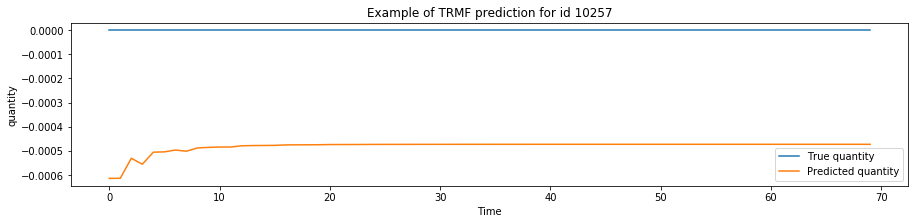

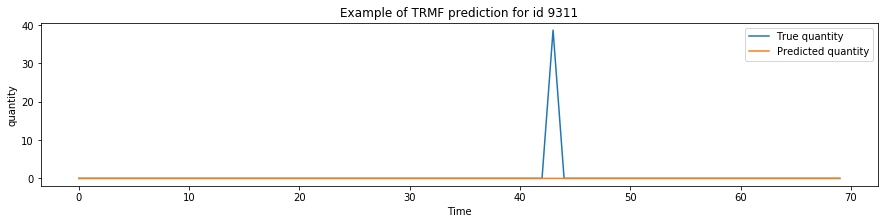

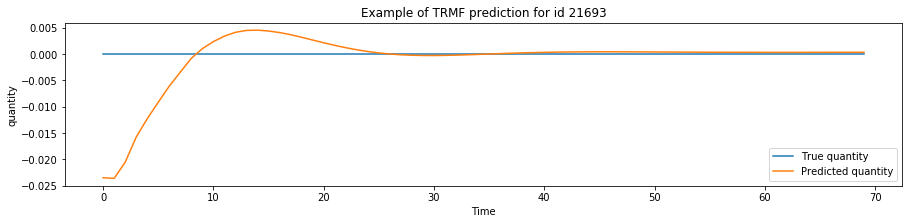

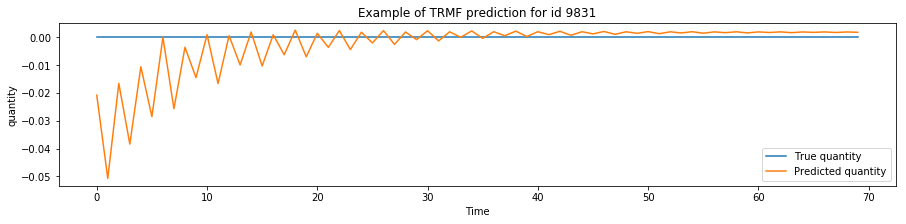

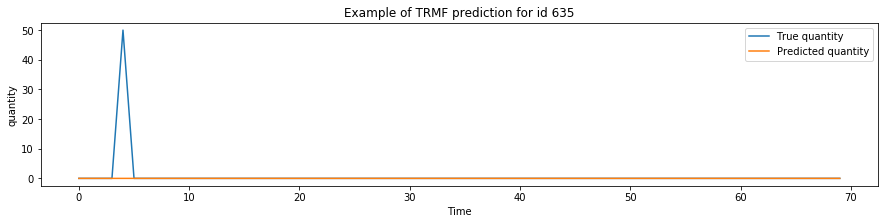

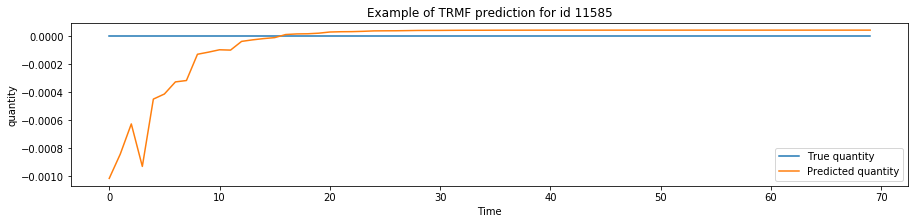

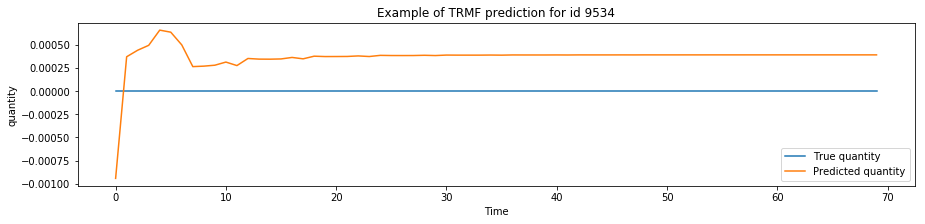

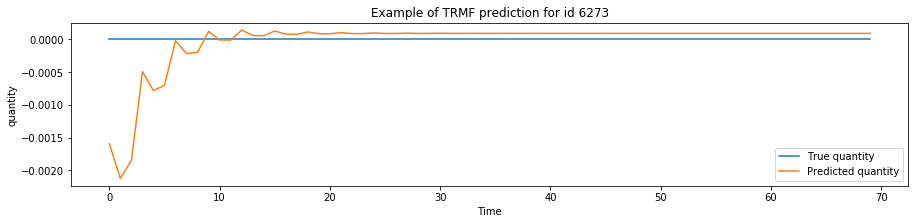

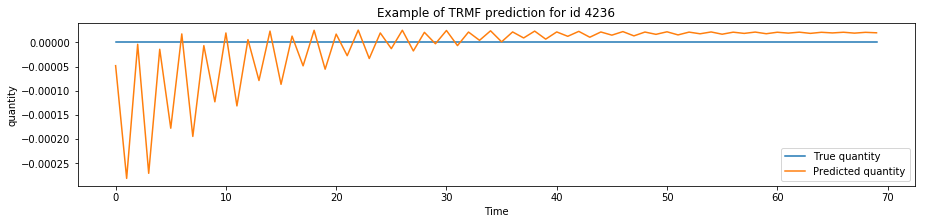

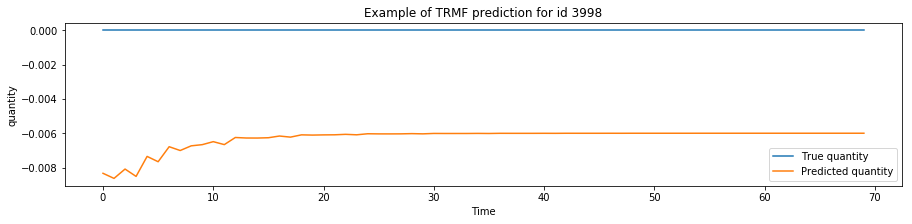

In [47]:
for x in range(10):
    rand = random.choice (test_targets.index)
    fig = plt.figure(figsize=(15,3))
    plt.plot(np.array(test_targets.loc[rand,:]).ravel(), label = 'True quantity')
    plt.plot(np.array(df_prediction.loc[rand,:]).ravel(), label = 'Predicted quantity')
    plt.xlabel('Time')
    plt.ylabel('quantity')
    plt.title('Example of TRMF prediction for id '+str(rand))
    plt.legend(); 